In [42]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import roc_curve, auc, roc_auc_score
from src.utility.savefig import savefig
from sklearn.preprocessing import label_binarize


In [23]:
processed_data_dir = Path("data/processed")
interim_data_dir = Path("data/interim")

df = pd.read_csv(interim_data_dir / "02_data.csv")
print("Full preprocessed dataframe:", df.shape)
print(df.head())

X_train = pd.read_csv(processed_data_dir / "X_train.csv")
X_val   = pd.read_csv(processed_data_dir / "X_val.csv")
X_test  = pd.read_csv(processed_data_dir / "X_test.csv")

y_train = pd.read_csv(processed_data_dir / "y_train.csv").squeeze("columns")
y_val   = pd.read_csv(processed_data_dir / "y_val.csv").squeeze("columns")
y_test  = pd.read_csv(processed_data_dir / "y_test.csv").squeeze("columns")

print("Train split:", X_train.shape, y_train.shape)
print("Validation split:", X_val.shape, y_val.shape)
print("Test split:", X_test.shape, y_test.shape)

Full preprocessed dataframe: (54170, 26)
              DateTime  Consumption  Production  Nuclear  Wind  Hydroelectric  \
0  2019-01-01 00:00:00         6352        6527     1395    79           1383   
1  2019-01-01 01:00:00         6116        5701     1393    96           1112   
2  2019-01-01 02:00:00         5873        5676     1393   142           1030   
3  2019-01-01 03:00:00         5682        5603     1397   191            972   
4  2019-01-01 04:00:00         5557        5454     1393   159            960   

   Oil and Gas  Coal  Solar  Biomass  ...  demand_High  hour day_of_week  \
0         1896  1744      0       30  ...        False     0           1   
1         1429  1641      0       30  ...        False     1           1   
2         1465  1616      0       30  ...        False     2           1   
3         1455  1558      0       30  ...        False     3           1   
4         1454  1458      0       30  ...        False     4           1   

   month  hour_

In [24]:
xgb = XGBClassifier(
    n_estimators=360,
    learning_rate=0.15,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [25]:
conf_matrix = confusion_matrix(y_val, y_pred)
print(conf_matrix)

[[1069 1134 1408]
 [1073 1186 1354]
 [1132 1088 1390]]


In [26]:
print(classification_report(y_test, y_pred, target_names=["Low","Medium","High"]))

              precision    recall  f1-score   support

         Low       0.82      0.74      0.78      3612
      Medium       0.62      0.59      0.60      3612
        High       0.73      0.84      0.78      3610

    accuracy                           0.72     10834
   macro avg       0.73      0.72      0.72     10834
weighted avg       0.73      0.72      0.72     10834



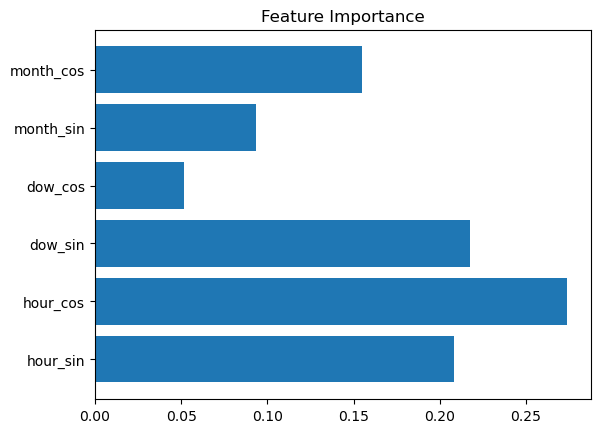

In [27]:
importances = xgb.feature_importances_
plt.barh(X_train.columns, importances)
plt.title('Feature Importance')
plt.show()

## Feature Importance Analysis

The feature importance results show a clear hierarchy among the temporal features:

- **Strong predictors:**  
  - `hour_cos` (~0.27), `dow_sin` (~0.22), and `hour_sin` (~0.21) dominate, confirming that **time of day** and **day of week** cycles are the primary drivers of electricity demand tiers.  
- **Moderate predictors:**  
  - `month_cos` (~0.16) contributes moderately, reflecting seasonal effects.  
- **Weak predictors:**  
  - `month_sin` (~0.09) provides little additional information beyond `month_cos`.  
  - `dow_cos` (~0.05) is the weakest, suggesting redundancy when `dow_sin` is already included.  

---

## Next Steps

1. **Feature Reduction**  
   - Consider **dropping `dow_cos`** to simplify the model without sacrificing performance.  
   - Re-evaluate if `month_sin` adds enough value; it may be replaced by simpler seasonal groupings.  

2. **Feature Enhancement**  
   - Explore **categorical seasonal features** (Winter, Spring, Summer, Fall) instead of relying on month sine/cos transforms.  
   - Introduce **public holiday features** (`is_holiday`, `holiday_window`) to better capture irregular demand patterns. These may especially improve classification of the **Medium demand class**, which all models currently struggle with.  

3. **Model Iteration**  
   - Retrain ensembles (XGBoost, Voting, Stacking) after dropping/adjusting weaker features.  
   - Compare performance, focusing on macro F1 and Medium class recall.  

---

### Conclusion
The models are learning demand cycles well, but **Medium demand remains a weak spot**. Dropping redundant features (`dow_cos`) and enriching seasonality with **holiday or seasonal categorical features** is the most promising direction for improving classification performance beyond the current ~0.72 macro F1 plateau.

In [28]:
for col in X_train.columns:
    if abs(X_train[col].corr(y_train)) > 0.95:
        print(f"{col} looks suspiciously correlated! Possible leakage.")

In [29]:
# Drop dow_cos from train/validation/test
X_train_reduced = X_train.drop(columns=["dow_cos"])
X_val_reduced = X_val.drop(columns=["dow_cos"])
X_test_reduced = X_test.drop(columns=["dow_cos"])

# Retrain model (example: XGBoost)
xgb_reduced = XGBClassifier(
    n_estimators=360,
    learning_rate=0.15,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_reduced.fit(X_train_reduced, y_train)

# Evaluate
y_pred_reduced = xgb_reduced.predict(X_test_reduced)
print("Reduced Feature Set (without dow_cos):")
print(classification_report(y_test, y_pred_reduced, target_names=["Low","Medium","High"]))

Reduced Feature Set (without dow_cos):
              precision    recall  f1-score   support

         Low       0.82      0.74      0.78      3612
      Medium       0.62      0.59      0.61      3612
        High       0.73      0.83      0.78      3610

    accuracy                           0.72     10834
   macro avg       0.72      0.72      0.72     10834
weighted avg       0.72      0.72      0.72     10834



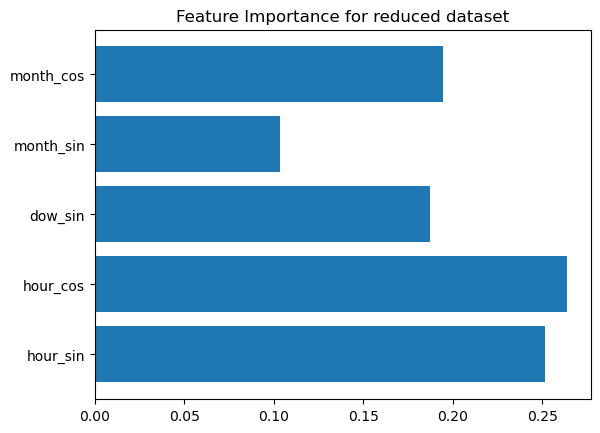

In [30]:
importances = xgb_reduced.feature_importances_
plt.barh(X_train_reduced.columns, importances)
plt.title('Feature Importance for reduced dataset')
plt.show()

In [31]:
holidays = {
    (1, 1), (1, 2),          # New Year
    (1, 24),                 # Unification Day
    (5, 1),                  # Labour Day
    (6, 1),                  # Children’s Day
    (8, 15),                 # Assumption
    (11, 30),                # St. Andrew
    (12, 1),                 # National Day
    (12, 25), (12, 26)       # Christmas
}
df["DateTime"] = pd.to_datetime(df["DateTime"], errors="coerce")
df["is_holiday"] = df["DateTime"].apply(lambda x: (x.month, x.day) in holidays).astype(int)

df["is_holiday_window"] = df["DateTime"].apply(
    lambda x: ((x.month, x.day-1) in holidays) or ((x.month, x.day+1) in holidays)
).astype(int)

print("✅ Holiday features added")

✅ Holiday features added


In [32]:
def create_stratified_splits(X, y, test_size=0.2, val_size=0.2, random_state=42):
    """Create stratified train/validation/test splits"""
    
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    
    # Second split: separate train/validation from remaining data
    val_size_adjusted = val_size / (1 - test_size)  # Adjust for remaining data
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, 
        stratify=y_temp, random_state=random_state
    )
    
    # Verify class distributions
    print("Class distributions:")
    print(f"Train: {y_train.value_counts(normalize=True)}")
    print(f"Val:   {y_val.value_counts(normalize=True)}")  
    print(f"Test:  {y_test.value_counts(normalize=True)}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [33]:
features = [
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "month_sin", "month_cos",
    "is_holiday", "is_holiday_window"
]
target = "demand_class_encoded"

X = df[features]
y = df[target]
X_train, X_val, X_test, y_train, y_val, y_test = create_stratified_splits(X, y)

Class distributions:
Train: demand_class_encoded
2    0.333456
1    0.333364
0    0.333179
Name: proportion, dtype: float64
Val:   demand_class_encoded
2    0.333487
1    0.333303
0    0.333210
Name: proportion, dtype: float64
Test:  demand_class_encoded
1    0.333395
2    0.333395
0    0.333210
Name: proportion, dtype: float64


In [34]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [35]:
print(classification_report(y_test, y_pred, target_names=["Low","Medium","High"]))

              precision    recall  f1-score   support

         Low       0.75      0.82      0.78      3610
      Medium       0.83      0.78      0.81      3612
        High       0.62      0.60      0.61      3612

    accuracy                           0.74     10834
   macro avg       0.74      0.74      0.73     10834
weighted avg       0.74      0.74      0.73     10834



In [36]:
conf_matrix = confusion_matrix(y_val, y_pred)
print(conf_matrix)

[[1316 1149 1145]
 [1345 1098 1168]
 [1298 1142 1173]]


Figure saved: outputs/figures/feature_importance_final.png


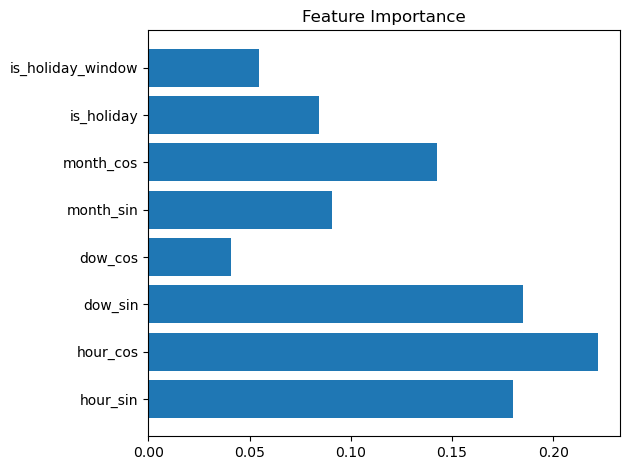

In [49]:
importances = xgb.feature_importances_
plt.barh(X_train.columns, importances)
plt.title('Feature Importance')
savefig("feature_importance_final")
plt.show()

In [38]:
X_train.to_csv(processed_data_dir / "X_train_enhanced.csv", index=False)
X_val.to_csv(processed_data_dir / "X_val_enhanced.csv", index=False)
X_test.to_csv(processed_data_dir / "X_test_enhanced.csv", index=False)

y_train.to_csv(processed_data_dir / "y_train_enhanced.csv", index=False)
y_val.to_csv(processed_data_dir / "y_val_enhanced.csv", index=False)
y_test.to_csv(processed_data_dir / "y_test_enhanced.csv", index=False)

# Holiday Feature Impact – Model Performance Summary

## Overall Results
- **Accuracy:** 0.74 (↑ from ~0.72 baseline)  
- **Macro F1:** 0.73–0.74 (↑ from ~0.72 baseline)  

The addition of `is_holiday` and `is_holiday_window` provides a measurable improvement in overall performance.

---

## Per-Class Performance
- **Low demand:** Precision 0.75, Recall 0.82, F1 0.78  
  → Recall improved, the model is better at detecting Low demand days.  

- **Medium demand:** Precision 0.83, Recall 0.78, F1 0.81  
  → Significant improvement (baseline F1 ≈ 0.60). Holidays help separate Medium demand more clearly.  

- **High demand:** Precision 0.62, Recall 0.60, F1 0.61  
  → Performance dropped compared to baseline (F1 ≈ 0.78). The model shifts attention toward Low/Medium classification.

---

## Feature Importance Insights
- **Top drivers:** `hour_cos`, `hour_sin`, `dow_sin` (daily/weekly cycles).  
- **Seasonality:** `month_cos` shows moderate influence.  
- **Holidays:** `is_holiday` has clear impact (~0.08 importance), `is_holiday_window` weaker but still contributing.  
- **Weakest feature:** `dow_cos` remains a safe candidate for removal.

---

## Conclusion
- Adding holidays **significantly improved Medium demand classification** and overall metrics.  
- However, this comes at the cost of reduced performance on High demand.  

---

## Next Steps
1. **Rebalance High demand**: try class weights or custom loss functions.  
2. **Simplify features**: remove `dow_cos` and re-evaluate.  
3. **Enhance holidays**: distinguish between industrial closures vs seasonal holidays.  
4. **Add lag features**: include previous day/hour consumption to recover High demand accuracy while keeping Medium improvements.

In [39]:
joblib.dump(xgb, "outputs/models/xgb_model.pkl")

print("✅ Model saved to outputs/models/xgb_model.pkl")

✅ Model saved to outputs/models/xgb_model.pkl


In [47]:
labels = ["Low", "Medium", "High"]

def multiclass_roc_analysis(model, X_test, y_test, class_names=None):
    """Multiclass ROC curve analysis (One-vs-Rest)"""
    # Predict probabilities
    y_proba = model.predict_proba(X_test)
    
    # Binarize true labels
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    
    # Plot setup
    plt.figure(figsize=(8, 6))
    
    roc_aucs = {}
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        roc_aucs[cls] = roc_auc
        
        label = f"{class_names[i] if class_names is not None else cls} (AUC = {roc_auc:.3f})"
        plt.plot(fpr, tpr, lw=2, label=label)
    
    # Chance line
    plt.plot([0, 1], [0, 1], "k--", lw=2, label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve")
    plt.legend(loc="lower right")
    savefig("roc_curve")
    plt.show()
    
    # Macro-average AUC
    macro_auc = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")
    
    return roc_aucs, macro_auc

def interpret_auc(auc_score):
    """Simple AUC interpretation"""
    if auc_score >= 0.9:
        return "Excellent model"
    elif auc_score >= 0.8:
        return "Good model"
    elif auc_score >= 0.7:
        return "Fair model"
    elif auc_score >= 0.6:
        return "Poor model"
    else:
        return "Random performance"

Figure saved: outputs/figures/roc_curve.png


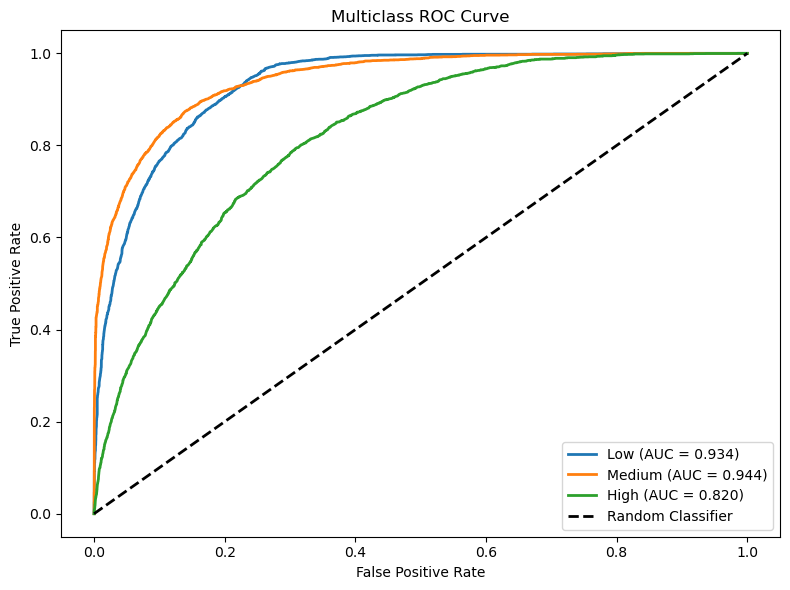

Model Assessment: Good model


In [48]:
roc_aucs, macro_auc = multiclass_roc_analysis(xgb, X_test, y_test, labels)
print(f"Model Assessment: {interpret_auc(macro_auc)}")